# 03 - Model Training: Isolation Forest vs XGBoost

本 Notebook 聚焦於：
- 無監督學習：Isolation Forest（不需要標籤）
- 監督學習：XGBoost（使用標籤）
- 比較兩種方法的差異與優勢
- 產出關鍵視覺化圖表用於 Demo


## 1. 環境設定與資料載入


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# 設定專案路徑
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / "data" / "processed"
FEATURES_PATH = DATA_DIR / "features.parquet"

# 確保 doc 目錄存在
DOC_DIR = PROJECT_ROOT / "doc"
DOC_DIR.mkdir(exist_ok=True)

# 設定繪圖風格（使用 seaborn 的設定，更相容）
sns.set_style("darkgrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
# plt.rcParams['font.sans-serif'] = ['Arial'] # 英文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 中文
warnings.filterwarnings('ignore')

print("✅ 環境設定完成")

✅ 環境設定完成


In [24]:
print("載入特徵資料...")
df = pd.read_parquet(FEATURES_PATH)

print(f"✅ 資料載入完成")
print(f"   資料筆數: {len(df):,}")
print(f"   特徵欄位數: {len(df.columns)}")
print(f"\n特徵欄位:")
print(df.columns.tolist())

# 檢查標籤分布
if 'label' in df.columns:
    print(f"\n標籤分布:")
    print(df['label'].value_counts().sort_index())
    print(f"\n異常比例(Botnet): {df['label'].sum() / len(df) * 100:.2f}%")


載入特徵資料...
✅ 資料載入完成
   資料筆數: 1,650,333
   特徵欄位數: 16

特徵欄位:
['src_ip', 'time_window', 'flow_count', 'total_bytes', 'total_packets', 'avg_duration', 'min_duration', 'max_duration', 'label', 'dst_ip_diversity', 'dst_port_diversity', 'protocol_diversity', 'bytes_per_flow', 'packets_per_flow', 'port_entropy', 'protocol_entropy']

標籤分布:
label
0    1640956
1       9377
Name: count, dtype: int64

異常比例(Botnet): 0.57%


## 2. 準備特徵與標籤


In [25]:
## 2. 準備特徵與標籤

print("=" * 60)
print("資料清理與特徵準備")
print("=" * 60)

# 選擇用於訓練的特徵（排除識別欄位和標籤）
feature_columns = [
    'flow_count', 'total_bytes', 'total_packets', 
    'avg_duration', 'min_duration', 'max_duration',
    'dst_ip_diversity', 'dst_port_diversity', 'protocol_diversity',
    'bytes_per_flow', 'packets_per_flow',
    'port_entropy', 'protocol_entropy'
]

# 檢查所有特徵欄位是否存在
missing_features = [col for col in feature_columns if col not in df.columns]
if missing_features:
    print(f"⚠️ 缺少特徵欄位: {missing_features}")
    feature_columns = [col for col in feature_columns if col in df.columns]

print(f"\n✅ 使用 {len(feature_columns)} 個特徵進行訓練")
print(f"特徵列表: {feature_columns}")

# 資料清理：處理無限值 (inf) 與缺失值
print("\n🧹 正在清理資料 (處理 Infinite/Null)...")
initial_rows = len(df)

# 檢查無限值
numeric_cols = df[feature_columns].select_dtypes(include=[np.number]).columns
inf_counts = {}
for col in numeric_cols:
    inf_count = np.isinf(df[col]).sum()
    if inf_count > 0:
        inf_counts[col] = inf_count

if inf_counts:
    print(f"   發現無限值:")
    for col, count in inf_counts.items():
        print(f"     {col}: {count:,} 個")
    # 將 inf 替換為 NaN（使用字典形式，避免版本問題）
    df.replace({np.inf: np.nan, -np.inf: np.nan}, inplace=True)
    print("   ✅ 無限值已轉換為 NaN")
else:
    print("   ✅ 未發現無限值")

# 檢查缺失值
nan_counts = df[feature_columns].isnull().sum()
total_nans = nan_counts.sum()
if total_nans > 0:
    print(f"\n   發現缺失值: {total_nans:,} 個")
    for col in feature_columns:
        if nan_counts[col] > 0:
            print(f"     {col}: {nan_counts[col]:,} 個 ({nan_counts[col]/len(df)*100:.2f}%)")
    
    # 用 0 填充缺失值（保留所有資料）
    df[feature_columns] = df[feature_columns].fillna(0)
    print("   ✅ 缺失值已用 0 填充")
else:
    print("\n   ✅ 未發現缺失值")

# 提取特徵和標籤
X = df[feature_columns].copy()
y = df['label'].copy() if 'label' in df.columns else None

# 最終資料統計
print(f"\n✅ 資料準備完成")
print(f"   初始筆數: {initial_rows:,}")
print(f"   最終筆數: {len(df):,}")
print(f"   特徵矩陣形狀: {X.shape}")
if y is not None:
    print(f"   標籤分布: 正常={sum(y==0):,}, 異常={sum(y==1):,}")
print("=" * 60)

資料清理與特徵準備

✅ 使用 13 個特徵進行訓練
特徵列表: ['flow_count', 'total_bytes', 'total_packets', 'avg_duration', 'min_duration', 'max_duration', 'dst_ip_diversity', 'dst_port_diversity', 'protocol_diversity', 'bytes_per_flow', 'packets_per_flow', 'port_entropy', 'protocol_entropy']

🧹 正在清理資料 (處理 Infinite/Null)...
   ✅ 未發現無限值

   ✅ 未發現缺失值

✅ 資料準備完成
   初始筆數: 1,650,333
   最終筆數: 1,650,333
   特徵矩陣形狀: (1650333, 13)
   標籤分布: 正常=1,640,956, 異常=9,377


## 3. Isolation Forest (無監督學習)


In [26]:
print("=" * 60)
print("Isolation Forest (無監督學習)")
print("=" * 60)

# 標準化特徵（Isolation Forest 對尺度敏感）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 訓練 Isolation Forest（使用預設參數）
print("\n訓練 Isolation Forest...")
# 計算預期異常比例（如果有標籤的話，否則使用預設值）
contamination = 0.05  # contamination: 預期異常比例，設為 0.05 (5%) 略高於實際比例以捕捉邊緣案例
if y is not None:
    contamination = y.sum() / len(y)
    print(f"   使用標籤計算的異常比例: {contamination:.4f}")

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=contamination,
    random_state=42,
    n_jobs=-1
)

# 訓練 (注意：只使用 X，不使用 label y)
iso_forest.fit(X_scaled)

# 預測異常分數（分數越低越可能是異常）
anomaly_scores = iso_forest.score_samples(X_scaled)
# Isolation Forest 的分數是負的，轉換為正數以便理解（分數越高越異常）
anomaly_scores_normalized = -anomaly_scores

print(f"✅ Isolation Forest 訓練完成")
print(f"   異常分數範圍: [{anomaly_scores_normalized.min():.4f}, {anomaly_scores_normalized.max():.4f}]")
print(f"   平均異常分數: {anomaly_scores_normalized.mean():.4f}")

# 如果有標籤，可以查看分數分布
if y is not None:
    print(f"\n異常分數統計（按真實標籤）:")
    print(f"   正常流量 (label=0): 平均分數 = {anomaly_scores_normalized[y==0].mean():.4f}")
    print(f"   異常流量 (label=1): 平均分數 = {anomaly_scores_normalized[y==1].mean():.4f}")


Isolation Forest (無監督學習)

訓練 Isolation Forest...
   使用標籤計算的異常比例: 0.0057
✅ Isolation Forest 訓練完成
   異常分數範圍: [0.3030, 0.8359]
   平均異常分數: 0.3549

異常分數統計（按真實標籤）:
   正常流量 (label=0): 平均分數 = 0.3539
   異常流量 (label=1): 平均分數 = 0.5157


## 4. 圖表 A - Isolation Forest 異常分數分布圖


📊 三張圖：分析、思考跟驗證
✅ 三面板分析圖已儲存至: C:\MyVS\NetworkAnomalyDetection\doc\isolation_forest_3_panels.png


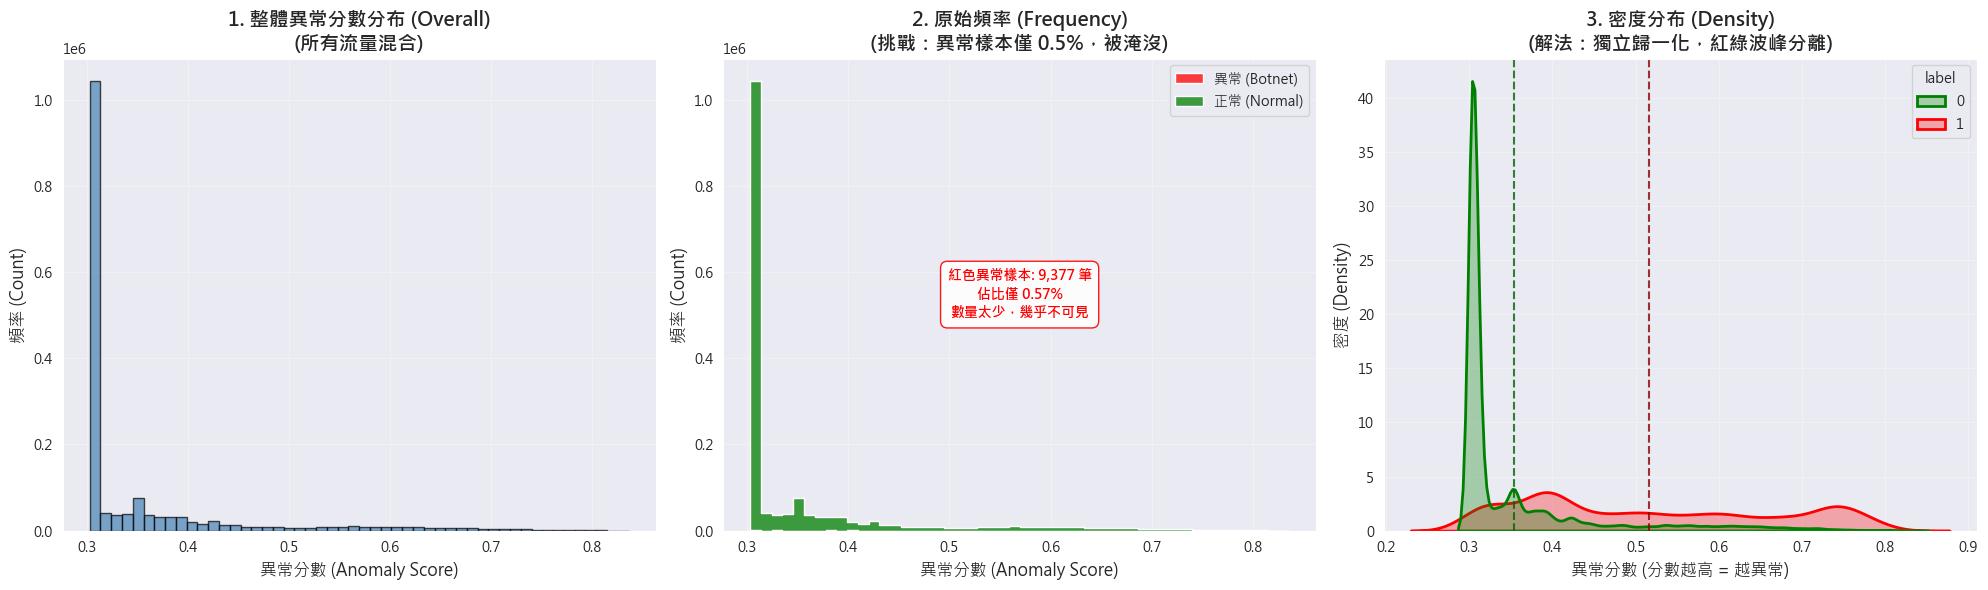

In [27]:
print("=" * 60)
print("📊 三張圖：分析、思考跟驗證")
print("=" * 60)

# 設定畫布大小 (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- 圖 1: 整體分布 (Raw Score Distribution) ---
# 目的：展示模型輸出的原始樣貌
ax1 = axes[0]
ax1.hist(anomaly_scores_normalized, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_title('1. 整體異常分數分布 (Overall)\n(所有流量混合)', fontsize=14, fontweight='bold')
ax1.set_xlabel('異常分數 (Anomaly Score)', fontsize=12)
ax1.set_ylabel('頻率 (Count)', fontsize=12)
ax1.grid(True, alpha=0.3)

# --- 圖 2: 按標籤頻率 (Frequency by Label) ---
# 目的：展示「資料不平衡」帶來的挑戰 (紅色幾乎看不見)
ax2 = axes[1]
sns.histplot(
    x=anomaly_scores_normalized, 
    hue=y, 
    multiple="stack", 
    bins=50,
    palette={0: 'green', 1: 'red'},
    element="step",
    ax=ax2
)
ax2.set_title('2. 原始頻率 (Frequency)\n(挑戰：異常樣本僅 0.5%，被淹沒)', fontsize=14, fontweight='bold')
ax2.set_xlabel('異常分數 (Anomaly Score)', fontsize=12)
ax2.set_ylabel('頻率 (Count)', fontsize=12)
ax2.legend(labels=['異常 (Botnet)', '正常 (Normal)'])
ax2.grid(True, alpha=0.3)

# 加上一個箭頭或文字框指出問題 (動態計算筆數版本)
anom_count = y.sum()
total_count = len(y)
anom_ratio = anom_count / total_count
    
# 建立動態文字
text_content = (
        f"紅色異常樣本: {anom_count:,} 筆\n"
        f"佔比僅 {anom_ratio:.2%}\n"
        f"數量太少，幾乎不可見"
    )
    
ax2.text(0.5, 0.5, text_content, 
             transform=ax2.transAxes, ha='center', va='center', color='red', fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='red', boxstyle='round,pad=0.5'))

# --- 圖 3: 密度分布 (Density / KDE) ---
# 目的：展示「解決方案」，透過歸一化比較分佈形狀
ax3 = axes[2]
sns.kdeplot(
    x=anomaly_scores_normalized, 
    hue=y, 
    fill=True, 
    common_norm=False,  # <--- 關鍵參數：獨立歸一化
    palette={0: 'green', 1: 'red'},
    alpha=0.3,
    linewidth=2,
    ax=ax3
)

# 加上平均線，強化數據佐證
mean_norm = anomaly_scores_normalized[y==0].mean()
mean_anom = anomaly_scores_normalized[y==1].mean()
ax3.axvline(mean_norm, color='darkgreen', linestyle='--', alpha=0.8)
ax3.axvline(mean_anom, color='darkred', linestyle='--', alpha=0.8)

ax3.set_title('3. 密度分布 (Density)\n(解法：獨立歸一化，紅綠波峰分離)', fontsize=14, fontweight='bold')
ax3.set_xlabel('異常分數 (分數越高 = 越異常)', fontsize=12)
ax3.set_ylabel('密度 (Density)', fontsize=12)
ax3.grid(True, alpha=0.3)

# 調整版面並儲存
plt.tight_layout()
output_path = DOC_DIR / 'isolation_forest_3_panels.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✅ 三面板分析圖已儲存至: {output_path}")
plt.show()

## 5. XGBoost (監督學習)


In [28]:
print("=" * 60)
print("XGBoost (監督學習)")
print("=" * 60)

if y is None:
    print("❌ 無法進行監督學習：缺少標籤資料")
else:
    # 分割訓練集和測試集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\n資料分割:")
    print(f"   訓練集: {len(X_train):,} 筆 (異常: {y_train.sum():,})")
    print(f"   測試集: {len(X_test):,} 筆 (異常: {y_test.sum():,})")
    
    # 訓練 XGBoost（使用預設參數）
    print("\n訓練 XGBoost...")
    xgb_model = xgb.XGBClassifier(
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    print("✅ XGBoost 訓練完成")
    
    # 評估模型
    train_score = xgb_model.score(X_train, y_train)
    test_score = xgb_model.score(X_test, y_test)
    print(f"\n模型準確率:")
    print(f"   訓練集: {train_score:.4f}")
    print(f"   測試集: {test_score:.4f}")


XGBoost (監督學習)

資料分割:
   訓練集: 1,320,266 筆 (異常: 7,502)
   測試集: 330,067 筆 (異常: 1,875)

訓練 XGBoost...
✅ XGBoost 訓練完成

模型準確率:
   訓練集: 0.9968
   測試集: 0.9965


## 6. 圖表 B - XGBoost 特徵重要性


圖表 B: XGBoost 特徵重要性

特徵重要性排序:
           feature  importance
       total_bytes    0.668120
      max_duration    0.083958
      avg_duration    0.077611
    bytes_per_flow    0.044812
        flow_count    0.038384
      min_duration    0.028853
dst_port_diversity    0.018748
  dst_ip_diversity    0.012815
protocol_diversity    0.010622
      port_entropy    0.007496
  packets_per_flow    0.004273
     total_packets    0.003942
  protocol_entropy    0.000366
✅ 圖表已儲存至: C:\MyVS\NetworkAnomalyDetection\doc\xgboost_feature_importance.png


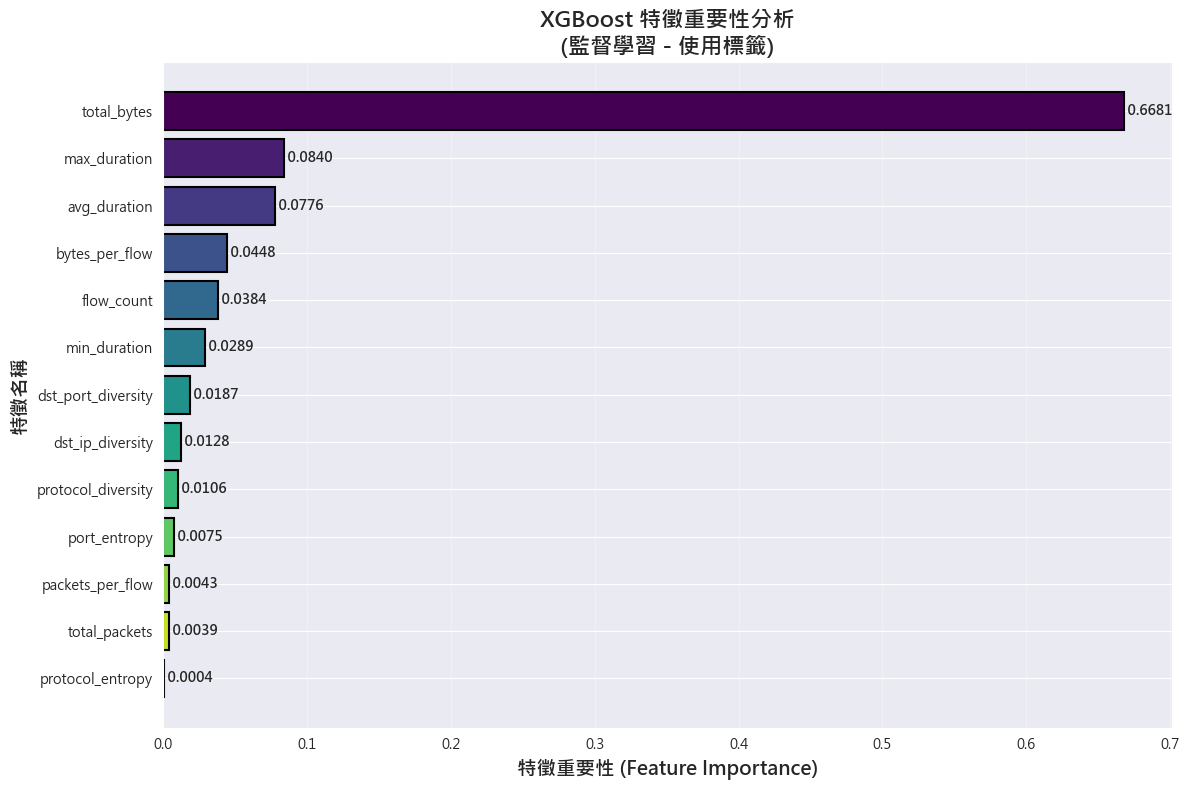


📊 重要特徵：
模型顯示以下特徵是區分 Botnet 的關鍵：
  • total_bytes: 0.6681
  • max_duration: 0.0840
  • avg_duration: 0.0776


In [29]:
print("=" * 60)
print("圖表 B: XGBoost 特徵重要性")
print("=" * 60)

if y is None:
    print("❌ 無法產生特徵重要性圖：缺少標籤資料")
else:
    # 取得特徵重要性
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n特徵重要性排序:")
    print(feature_importance.to_string(index=False))
    
    # 建立圖表
    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance)))
    bars = plt.barh(range(len(feature_importance)), 
                    feature_importance['importance'], 
                    color=colors, edgecolor='black', linewidth=1.5)
    
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('特徵重要性 (Feature Importance)', fontsize=14, fontweight='bold')
    plt.ylabel('特徵名稱', fontsize=14, fontweight='bold')
    plt.title('XGBoost 特徵重要性分析\n(監督學習 - 使用標籤)', fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()  # 最重要的特徵在頂部
    
    # 添加數值標籤
    for i, (idx, row) in enumerate(feature_importance.iterrows()):
        plt.text(row['importance'], i, f" {row['importance']:.4f}", 
                va='center', fontsize=10, fontweight='bold')
    
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    output_path = DOC_DIR / 'xgboost_feature_importance.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ 圖表已儲存至: {output_path}")
    plt.show()
    
    # 提出重要特徵
    print("\n" + "=" * 60)
    print("📊 重要特徵：")
    print("=" * 60)
    top_features = feature_importance.head(3)
    print("模型顯示以下特徵是區分 Botnet 的關鍵：")
    for idx, row in top_features.iterrows():
        print(f"  • {row['feature']}: {row['importance']:.4f}")
    print("=" * 60)


## 7. 結論與比較

### Isolation Forest vs XGBoost

| 特性 | Isolation Forest | XGBoost |
|------|------------------|---------|
| **學習方式** | 無監督學習 | 監督學習 |
| **需要標籤** | ❌ 不需要 | ✅ 需要 |
| **適用場景** | 未知異常類型、標籤稀少 | 有明確標籤、需要解釋性 |
| **優勢** | 能發現未知異常模式 | 準確率高、可解釋性強 |
| **輸出** | 異常分數 | 分類結果 + 特徵重要性 |

### 實務建議

1. **初期探索階段**：使用 Isolation Forest 快速識別異常模式
2. **標籤充足後**：使用 XGBoost 獲得更高準確率和可解釋性
3. **混合策略**：結合兩種方法，Isolation Forest 用於發現新異常，XGBoost 用於已知異常分類
